# Plot effects of dicodon length and periodicity on mRNA levels

## Load libraries and define analysis-specific parameters

- We need to install both rsample and rasilabRtemplates in the Docker / Singularity container (or R conda environement?)

In [204]:
library(Biostrings)
library(tidyverse)
library(rasilabRtemplates)
library(cowplot)


insert_reads_cutoff <- 200 # The insert should get at least 200 reads across gRNA or mRNA
n_barcodes_cutoff <- 6 # The insert should have at least 6 barcodes across gRNA and mRNA after above cutoff

# Color-blind friendly palette. See http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

## Read back barcode counts 

This is calculated in [plot_alignment_statistics.ipynb](plot_alignment_statistics.md).

In [205]:
barcode_counts <- read_tsv('../tables/sample_insert_barcode_counts.tsv.gz') %>% 
  print()

Rows: 84782 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): sample_id, sample_name, library_type, linkage_ref
dbl (4): insert_num, barcode_num, barcode_count, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 84,782 × 8
   sample_id sample_name insert_num barcode_num barcode_count linkage_count
   <chr>     <chr>            <dbl>       <dbl>         <dbl>         <dbl>
 1 107p7     didi_grna_1         86       47695          4582            26
 2 107p7     didi_grna_1         22       17334          4086             6
 3 107p7     didi_grna_1        172        6711          4078             1
 4 107p7     didi_grna_1         20        5501          4068             1
 5 107p7     didi_grna_1        275        2109          3889             1
 6 107p7     didi_grna_1         54       46374          3821            25
 7 107p7     didi_grna_1        150       49997          3797            29
 8 107p7     didi_grna_1        236        1823          3785             1
 9 107p7     didi_grna_1         90       41296          3778            20
10 107p7     didi_grna_1        227       26592          3694            11
# … with 84,772 more rows, and 2 more variables: library_type <ch

In [206]:
replicate_annotations <- read_csv("../annotations/replicate_annotations.csv") %>% 
  select(sample_num, sample_name, sample_type, replicate) %>% 
  print()

Rows: 4 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sample_id, illumina_index, sample_name, sample_type, linkage_ref
dbl (2): replicate, sample_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 4 × 4
  sample_num sample_name sample_type replicate
       <dbl> <chr>       <chr>           <dbl>
1          1 didi_grna_1 grna                1
2          2 didi_grna_2 grna                2
3          3 didi_mrna_1 mrna                1
4          4 didi_mrna_2 mrna                2



## Read insert annotations 

In [207]:

insert_annotations <- read_tsv("../../pool2_linkage/annotations/insert_annotations.tsv") %>% 
  arrange(insert_num) %>%
  print()

Rows: 317 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): seq, insert_name
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 317 × 3
   insert_num seq                                              insert_name      
        <dbl> <chr>                                            <chr>            
 1          0 AAGATCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGC varydicodonrepea…
 2          1 AAGATCAAGATCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGC varydicodonrepea…
 3          2 AAGATCAAGATCAAGATCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGC varydicodonrepea…
 4          3 AAGATCAAGATCAAGATCAAGATCTCCGGCTCCGGCTCCGGCTCCGGC varydicodonrepea…
 5          4 AAGATCAAGATCAAGATCAAGATCAAGATCTCCGGCTCCGGCTCCGGC varydicodonrepea…
 6          5 AAGATCAAGATCAAGATCAAGATCAAGATCAAGATCTCCGGCTCCGGC varydicodonrepea…
 7          6 AAGATCAAGATCAAGATCAAGATCAAGATCAAGATCAAGATCTCCGGC varydicodonrepea…
 8          7 AAGATCAAGATCAAGATCAAGATCAAGATCAAGATCAAGATCAAGATC varydicodonrepea…
 9          8 AAGTTCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGC varydicodonrepea…
10          9 AAGTTCAAGTTCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGCTCCGGC varydicodonrepea…
# … with

## Combine counts and annotations

In [208]:
counts <- barcode_counts %>% 
  left_join(replicate_annotations, by  = "sample_name") %>% 
  left_join(insert_annotations, by = "insert_num") %>% 
  print()

counts

# A tibble: 84,782 × 13
   sample_id sample_name insert_num barcode_num barcode_count linkage_count
   <chr>     <chr>            <dbl>       <dbl>         <dbl>         <dbl>
 1 107p7     didi_grna_1         86       47695          4582            26
 2 107p7     didi_grna_1         22       17334          4086             6
 3 107p7     didi_grna_1        172        6711          4078             1
 4 107p7     didi_grna_1         20        5501          4068             1
 5 107p7     didi_grna_1        275        2109          3889             1
 6 107p7     didi_grna_1         54       46374          3821            25
 7 107p7     didi_grna_1        150       49997          3797            29
 8 107p7     didi_grna_1        236        1823          3785             1
 9 107p7     didi_grna_1         90       41296          3778            20
10 107p7     didi_grna_1        227       26592          3694            11
# … with 84,772 more rows, and 7 more variables: library_type <c

sample_id,sample_name,insert_num,barcode_num,barcode_count,linkage_count,library_type,linkage_ref,sample_num,sample_type,replicate,seq,insert_name
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
107p7,didi_grna_1,86,47695,4582,26,grna,didi_linkage_1,1,grna,1,CGTGAACGTGAACGTGAACGTGAACGTGAACGTGAACGTGAATCCGGC,varydicodonrepeatlength_CGTGAA_7
107p7,didi_grna_1,22,17334,4086,6,grna,didi_linkage_1,1,grna,1,AGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGTCCGGC,varydicodonrepeatlength_AGAGAG_7
107p7,didi_grna_1,172,6711,4078,1,grna,didi_linkage_1,1,grna,1,AAAGTCAAAGTCAAAGTCAAAGTCAGTTTCAGTTTCAGTTTCAGTTTC,mixdicodons_AAAGTC_AGTTTC_4
107p7,didi_grna_1,20,5501,4068,1,grna,didi_linkage_1,1,grna,1,AGAGAGAGAGAGAGAGAGAGAGAGAGAGAGTCCGGCTCCGGCTCCGGC,varydicodonrepeatlength_AGAGAG_5
107p7,didi_grna_1,275,2109,3889,1,grna,didi_linkage_1,1,grna,1,TCCAGTTTCTCCAGTTTCTCCAGTTTCTCCAGTTTCTCCAGTTTCTCC,reorderdicodon_AGTTTC_1
107p7,didi_grna_1,54,46374,3821,25,grna,didi_linkage_1,1,grna,1,ATGATGATGATGATGATGATGATGATGATGATGATGATGATGTCCGGC,varydicodonrepeatlength_ATGATG_7
107p7,didi_grna_1,150,49997,3797,29,grna,didi_linkage_1,1,grna,1,TTGATGTTGATGTTGATGTTGATGTTGATGTTGATGTTGATGTCCGGC,varydicodonrepeatlength_TTGATG_7
107p7,didi_grna_1,236,1823,3785,1,grna,didi_linkage_1,1,grna,1,GTCAAACATCGCGTCAAACATCGCGTCAAACATCGCGTCAAACATCGC,mixdicodons_GTCAAA_CATCGC_1
107p7,didi_grna_1,90,41296,3778,20,grna,didi_linkage_1,1,grna,1,CTCATACTCATACTCATATCCGGCTCCGGCTCCGGCTCCGGCTCCGGC,varydicodonrepeatlength_CTCATA_3


### Plot correlation between mRNA and gDNA counts for all inserts in both samples


`summarise()` has grouped output by 'insert_num'. You can override using the `.groups` argument.


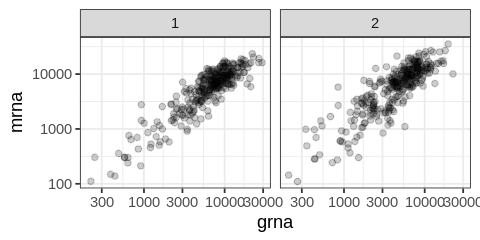

In [209]:
options(repr.plot.width=4, repr.plot.height=2)

counts %>% 
  select(barcode_num, sample_type, replicate, barcode_count, insert_num) %>%
  pivot_wider(names_from = sample_type, values_from = barcode_count) %>%
  drop_na() %>%
  filter(grna > 100, mrna > 100) %>% 
  group_by(insert_num, replicate) %>%
  arrange(-(grna + mrna)) %>%
  # This selects the number of barcodes for each sample
  # slice(1:3) %>%
  summarize(grna = sum(grna), mrna = sum(mrna)) %>% 
  ungroup() %>%
  arrange(insert_num, replicate) %>%
  ggplot(aes(x = grna, y = mrna)) +
  facet_wrap(~ replicate) +
  geom_point(alpha = 0.2) +
  scale_x_log10() +
  scale_y_log10() +
  theme_bw()

## Function for bootstrap mRNA levels

In [210]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$grna))
}

## Calculate mRNA levels for each insert

- Calculate lfc and standard deviation using the bootstrapping function above

In [211]:
lfc <- counts %>% 
  select(barcode_num, sample_type, replicate, barcode_count, insert_num) %>%
  pivot_wider(names_from = sample_type, values_from = barcode_count) %>%
  drop_na() %>%
  group_by(insert_num, replicate) %>% 
  nest() %>% 
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  group_by(replicate) %>%
  mutate(lfc = lfc - median(lfc)) %>%
  ungroup() %>%
  print()


# A tibble: 634 × 4
   replicate insert_num     lfc lfc_sd
       <dbl>      <dbl>   <dbl>  <dbl>
 1         1         86 -0.0736  0.296
 2         1         22 -2.01    0.364
 3         1        172 -1.92    0.420
 4         1         20 -0.343   0.287
 5         1        275  0.630   0.263
 6         1         54  0.640   0.424
 7         1        150  0.843   0.369
 8         1        236 -0.638   0.395
 9         1         90 -0.221   0.403
10         1        227  0.0832  0.414
# … with 624 more rows



## Test read and barcode count cutoffs

- Filter for inserts with at least 6 barcodes total and 200 reads total

- Log fold change is log2(mRNA/gRNA) (calculated above in the lfc bootstrapp function) and is median-normalized across the full library.

- Effects are roughly the same, since individual inserts have deep coverage. Data actually gets a bit nosier after aplying cutoffs, due to replicates having similar effects but slightly different depths. So let's keep the bootstrapping method above for these data, since better biological replicate aggreement is more meaningful than an arbitrary read count cutoffs.  

In [212]:
cutoff_lfc <- counts %>% 
  group_by(insert_num, sample_name) %>%
  summarize(count = sum(barcode_count), n_barcodes = dplyr::n()) %>%
  ungroup() %>%
  inner_join(insert_annotations, by = "insert_num") %>% 
  # filter for >6 barcodes >200 total reads 
  filter(sum(count) >= insert_reads_cutoff, sum(n_barcodes) >= n_barcodes_cutoff) %>%
  ungroup() %>% 
  # Convert sample name to replicate #
  mutate(replicate = substring(sample_name, 11))  %>%
  # remove "didi_" from gRNA and mRNA indicators
  mutate(sample_name = substring(sample_name, 6, 9)) %>%
  pivot_wider(names_from = sample_name, values_from = c("count", "n_barcodes")) %>% 
  mutate(lfc = log2(count_mrna) - log2(count_grna)) %>% 
  # median normalize this biaaatch
  mutate(lfc = lfc - median(lfc)) %>%
  arrange(lfc) %>%
  print()  

`summarise()` has grouped output by 'insert_num'. You can override using the `.groups` argument.


# A tibble: 634 × 9
   insert_num seq    insert_name replicate count_grna count_mrna n_barcodes_grna
        <dbl> <chr>  <chr>       <chr>          <dbl>      <dbl>           <int>
 1        141 TACAA… varydicodo… 1              13253        519              39
 2        185 AGTTT… mixdicodon… 1              24536       1115              65
 3        257 TTCAG… mixdicodon… 1              22124       1047              58
 4          7 AAGAT… varydicodo… 1               9717        557              37
 5        170 AAAGT… mixdicodon… 1              26785       1644              66
 6         47 ATCAT… varydicodo… 1              15803       1121              51
 7         70 CGCCA… varydicodo… 1              17969       1277              60
 8        235 GTCAA… mixdicodon… 1              18677       1361              53
 9        247 TTCAG… mixdicodon… 2              14148       1057              51
10        232 GTCAA… mixdicodon… 1              17085       1491              53
# … with

## Compare insert mRNA level effects of the two replicates

# A tibble: 317 × 3
   insert_num   lfc_1   lfc_2
        <dbl>   <dbl>   <dbl>
 1         86 -0.0736  0.101 
 2         22 -2.01   -1.41  
 3        172 -1.92   -2.17  
 4         20 -0.343  -0.0899
 5        275  0.630   0.488 
 6         54  0.640   1.31  
 7        150  0.843   0.484 
 8        236 -0.638  -0.254 
 9         90 -0.221   1.38  
10        227  0.0832  0.429 
# … with 307 more rows


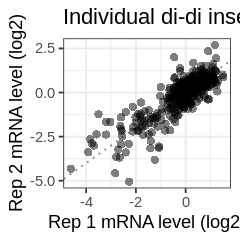

In [213]:
options(repr.plot.width=2, repr.plot.height=2)

plot_data <- lfc %>% 
  select(insert_num, replicate, lfc) %>% 
  pivot_wider(names_from = replicate, values_from = lfc, names_prefix = "lfc_") %>%
  print()

plot_data %>% 
  ggplot(aes(x = lfc_1, y = lfc_2)) +
  geom_point(alpha = 0.5, shape = 16, size = 2)  +
  geom_abline(slope = 1, linetype = "dotted", alpha = 0.5) +
  labs(x = "Rep 1 mRNA level (log2)", y = "Rep 2 mRNA level (log2)",
       title = "Individual di-di inserts") +
  theme_bw() 

## Which inserts have lowest mRNA levels?

In [214]:
insert_lfc <- lfc %>% 
  left_join(insert_annotations, by = "insert_num") %>% 
  group_by(insert_num) %>% 
  mutate(mean_lfc = mean(lfc)) %>% 
  ungroup() %>% 
  arrange(mean_lfc) %>% 
  select(-insert_num) %>% 
  mutate(insert = as.character(translate(DNAStringSet(seq), no.init.codon = T))) %>% 
  write_tsv("../tables/insert_mrna_lfc.tsv.gz")

insert_lfc

cutoff_insert_lfc <- cutoff_lfc %>% 
  # left_join(insert_annotations, by = "insert_num") %>% 
  group_by(insert_num) %>% 
  mutate(mean_lfc = mean(lfc)) %>% 
  ungroup() %>% 
  arrange(mean_lfc) %>% 
  select(-insert_num) %>% 
  mutate(insert = as.character(translate(DNAStringSet(seq), no.init.codon = T))) 

cutoff_insert_lfc

replicate,lfc,lfc_sd,seq,insert_name,mean_lfc,insert
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,-4.612645,1.2896034,TACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTCCGGCTCCGGC,varydicodonrepeatlength_TACAAG_6,-4.465646,YKYKYKYKYKYKSGSG
2,-4.318647,1.3026861,TACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTCCGGCTCCGGC,varydicodonrepeatlength_TACAAG_6,-4.465646,YKYKYKYKYKYKSGSG
1,-2.834102,0.6243789,TACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTACAAG,varydicodonrepeatlength_TACAAG_8,-3.703522,YKYKYKYKYKYKYKYK
2,-4.572943,0.6828467,TACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTACAAG,varydicodonrepeatlength_TACAAG_8,-3.703522,YKYKYKYKYKYKYKYK
1,-2.269574,0.8334966,CGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCAT,varydicodonrepeatlength_CGCCAT_8,-3.658879,RHRHRHRHRHRHRHRH
2,-5.048185,1.2213045,CGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCAT,varydicodonrepeatlength_CGCCAT_8,-3.658879,RHRHRHRHRHRHRHRH
1,-3.919213,1.4681352,AAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTC,mixdicodons_AAAGTC_AGTTTC_1,-3.650581,KVSFKVSFKVSFKVSF
2,-3.381949,0.7412990,AAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTC,mixdicodons_AAAGTC_AGTTTC_1,-3.650581,KVSFKVSFKVSFKVSF
1,-3.688906,0.7565528,AGTTTCAAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTCAAAGTC,mixdicodons_AGTTTC_AAAGTC_1,-3.348520,SFKVSFKVSFKVSFKV


seq,insert_name,replicate,count_grna,count_mrna,n_barcodes_grna,n_barcodes_mrna,lfc,mean_lfc,insert
<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
TACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTCCGGCTCCGGC,varydicodonrepeatlength_TACAAG_6,1,13253,519,39,21,-4.659915,-3.703576,YKYKYKYKYKYKSGSG
TACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTCCGGCTCCGGC,varydicodonrepeatlength_TACAAG_6,2,6416,946,36,21,-2.747237,-3.703576,YKYKYKYKYKYKSGSG
AAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTC,mixdicodons_AAAGTC_AGTTTC_1,1,26785,1644,66,34,-4.011618,-3.548641,KVSFKVSFKVSFKVSF
AAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTC,mixdicodons_AAAGTC_AGTTTC_1,2,15427,1799,72,44,-3.085665,-3.548641,KVSFKVSFKVSFKVSF
TTCAGTGTCAAATTCAGTGTCAAATTCAGTGTCAAATTCAGTGTCAAA,mixdicodons_TTCAGT_GTCAAA_1,1,22124,1047,58,30,-4.386754,-3.532029,FSVKFSVKFSVKFSVK
TTCAGTGTCAAATTCAGTGTCAAATTCAGTGTCAAATTCAGTGTCAAA,mixdicodons_TTCAGT_GTCAAA_1,2,15869,2456,53,30,-2.677303,-3.532029,FSVKFSVKFSVKFSVK
TACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTACAAG,varydicodonrepeatlength_TACAAG_8,2,14470,1267,55,44,-3.499051,-3.392553,YKYKYKYKYKYKYKYK
TACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTACAAGTACAAG,varydicodonrepeatlength_TACAAG_8,1,17844,1811,63,40,-3.286055,-3.392553,YKYKYKYKYKYKYKYK
AGTTTCAAAGTCAGTTTCAAAGTCAGTTTCAAAGTCAGTTTCAAAGTC,mixdicodons_AGTTTC_AAAGTC_1,1,24536,1115,65,36,-4.445259,-3.387627,SFKVSFKVSFKVSFKV


## How does mRNA level vary with dicodon repeat length?

# A tibble: 168 × 8
   replicate    lfc lfc_sd seq              dicodon repeat_length mean_lfc diaa 
       <dbl>  <dbl>  <dbl> <chr>            <chr>   <chr>            <dbl> <fct>
 1         1 -3.58   1.20  AAGATCAAGATCAAG… AAGATC  8               -2.98  KI   
 2         1 -1.48   0.465 AAGATCAAGATCAAG… AAGATC  7               -1.61  KI   
 3         1 -0.624  0.559 AAGATCAAGATCAAG… AAGATC  6               -1.38  KI   
 4         1 -1.12   0.525 AAGATCAAGATCAAG… AAGATC  5               -1.53  KI   
 5         1 -0.343  0.305 AAGATCAAGATCAAG… AAGATC  4               -0.672 KI   
 6         1  0.222  0.292 AAGATCAAGATCAAG… AAGATC  3                0.197 KI   
 7         1  0.272  0.370 AAGATCAAGATCTCC… AAGATC  2                0.482 KI   
 8         1 -0.441  0.314 AAGATCTCCGGCTCC… AAGATC  1                0.212 KI   
 9         1 -2.60   0.441 AAGTTCAAGTTCAAG… AAGTTC  8               -2.00  KF   
10         1 -3.03   0.563 AAGTTCAAGTTCAAG… AAGTTC  7               -2.35  KF   
# … with

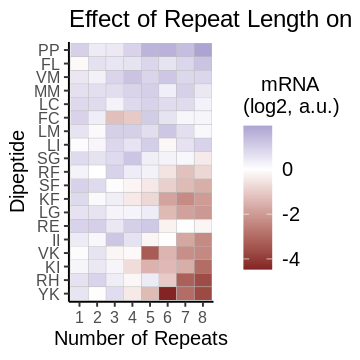

In [215]:
options(repr.plot.width=3, repr.plot.height=3)

plot_data <- insert_lfc %>%
  filter(str_detect(insert_name, "varydicodonrepeatlength")) %>% 
  separate(insert_name, c("insert_type", "dicodon", "repeat_length")) %>% 
  mutate(diaa = as.character(translate(DNAStringSet(dicodon,), no.init.codon = T))) %>% 
  group_by(seq) %>%
  slice(1) %>% 
  ungroup() %>% 
  group_by(diaa) %>%
  mutate(temp = min(mean_lfc[repeat_length == "8"])) %>%
  ungroup() %>%
  mutate(diaa = fct_reorder(diaa, -temp)) %>%
  select(-insert, - insert_type, -temp) %>%
  print()

plot_data %>% 
  ggplot(aes(x = repeat_length, y = fct_rev(diaa), fill = mean_lfc)) +
  geom_tile(color = 'grey') +
  scale_fill_gradient2() +
  labs(x = "Number of Repeats", y = "Dipeptide", fill = "   mRNA\n(log2, a.u.)",
       title = "Effect of Repeat Length on mRNA level")  

## Plot length effects for destabilizing dipeptide only

- set RH8 as lowest for heatmap purposes, since YK6 being lowest is likely suprious. 

# A tibble: 72 × 8
   replicate    lfc lfc_sd seq              dicodon repeat_length mean_lfc diaa 
       <dbl>  <dbl>  <dbl> <chr>            <chr>   <chr>            <dbl> <fct>
 1         1 -3.50   0.550 ATCATCATCATCATC… ATCATC  8              -2.37   II   
 2         1 -2.41   0.574 ATCATCATCATCATC… ATCATC  7              -1.76   II   
 3         1 -0.159  0.391 ATCATCATCATCATC… ATCATC  6               0.0178 II   
 4         1 -0.129  0.501 ATCATCATCATCATC… ATCATC  5              -0.175  II   
 5         1  0.295  0.283 ATCATCATCATCATC… ATCATC  4               0.605  II   
 6         1  0.816  0.333 ATCATCATCATCATC… ATCATC  3               1.17   II   
 7         1  0.497  0.291 ATCATCATCATCTCC… ATCATC  2               0.159  II   
 8         1  0.339  0.350 ATCATCTCCGGCTCC… ATCATC  1               0.421  II   
 9         1 -2.60   0.441 AAGTTCAAGTTCAAG… AAGTTC  8              -2.00   KF   
10         1 -3.03   0.563 AAGTTCAAGTTCAAG… AAGTTC  7              -2.35   KF   
# … with 

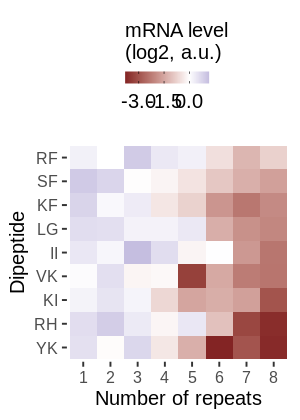

In [216]:
options(repr.plot.width=2.5, repr.plot.height=3.5)

plot_data <- insert_lfc %>% 
  filter(str_detect(insert_name, "varydicodonrepeatlength")) %>% 
  separate(insert_name, c("insert_type", "dicodon", "repeat_length")) %>% 
  # we skip these two dicodons and plot them separately since they are peculiar, 
  # they have another synonymous dicodon in this group
  filter(!dicodon %in% c("AGAGAG", "CTCATA")) %>%
  mutate(diaa = as.character(translate(DNAStringSet(dicodon,), no.init.codon = T))) %>% 
  group_by(insert) %>%
  slice(1) %>%
  ungroup() %>%
  group_by(diaa) %>%
  mutate(temp = min(mean_lfc[repeat_length == "8"])) %>%
  ungroup() %>%
  filter(temp < -0.5) %>% 
  mutate(diaa = fct_reorder(diaa, -temp)) %>%
  select(-insert, - insert_type, -temp) %>%
  mutate(mean_lfc = case_when(mean_lfc < -3.8 ~ -3.8, T ~ mean_lfc)) %>% 
  print()

plot_data %>% 
  complete(diaa, repeat_length) %>% 
  ggplot(aes(x = repeat_length, y = fct_rev(diaa), fill = mean_lfc)) +
  geom_tile() +
  scale_fill_gradient2(breaks = c(0, -1.5, -3),
                       na.value = "grey50", 
                       guide = guide_colorbar(barwidth = 3.5, barheight = 0.5, ticks.colour = "black", title.position = "top")) +
  labs(x = "Number of repeats", y = "Dipeptide", fill = "mRNA level\n(log2, a.u.)") +
  theme(axis.line = element_blank(), legend.position = "top") 
  
ggsave("../figures/destabilizing_dipeptide_length_effect.pdf", width = 2.5, height = 3.5)   

## Show replicability for above plot

# A tibble: 72 × 4
   diaa  repeat_length lfc_1 lfc_2
   <chr> <chr>         <dbl> <dbl>
 1 YK    6             -4.61 -4.32
 2 YK    8             -2.83 -4.57
 3 RH    8             -2.27 -5.05
 4 VK    5             -3.77 -2.88
 5 RH    7             -2.79 -3.65
 6 KI    8             -3.58 -2.37
 7 YK    7             -2.71 -3.23
 8 VK    8             -2.57 -2.19
 9 II    8             -3.50 -1.23
10 KF    7             -3.03 -1.67
# … with 62 more rows


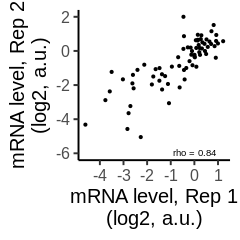

In [217]:
options(repr.plot.width=2, repr.plot.height=2)

plot_data <- insert_lfc %>% 
  filter(str_detect(insert_name, "varydicodonrepeatlength")) %>% 
  separate(insert_name, c("insert_type", "dicodon", "repeat_length")) %>% 
  # we skip these two dicodons and plot them separately since they are peculiar
  filter(!dicodon %in% c("AGAGAG", "CTCATA")) %>%
  mutate(diaa = as.character(translate(DNAStringSet(dicodon,), no.init.codon = T))) %>% 
  group_by(diaa) %>%
  mutate(temp = min(mean_lfc[repeat_length == "8"])) %>%
  ungroup() %>%
  filter(temp < -0.5) %>% 
  select(replicate, lfc, diaa, repeat_length) %>% 
  mutate(replicate = as.character(replicate)) %>% 
  pivot_wider(names_from = replicate, values_from = lfc, names_prefix = "lfc_") %>%
  print()

plot_data %>% 
  ggplot(aes(x = lfc_1, y = lfc_2)) +
  geom_point(size = 0.5) +
  labs(x = "mRNA level, Rep 1\n(log2, a.u.)", y = "mRNA level, Rep 2\n(log2, a.u.)") +
  annotate("text", x=0, y=-6, label="rho = 0.84", size = 2)

## Read in data from Pool1 8x Dicodon experiment

- Adjust such that we can use this as an additioanl replciate for plotting 8x dicodon test effects 

In [218]:
all_8xdiaa_data <- read_tsv("../../pool1_mrna/tables/8xdipeptide_lfc.tsv.gz") %>% 
  select(count_grna, count_mrna, n_barcodes_grna, n_barcodes_mrna, diaa) %>% 
  group_by(diaa) %>%
  summarize_all(sum) %>%
  ungroup() %>%
  mutate(lfc = log2(count_mrna / count_grna)) %>%
  mutate(lfc = lfc -  median(lfc)) %>%
  arrange(lfc) %>%
  mutate(diaa1 = diaa, diaa2 = diaa, repeat_length = 8) %>% 
  mutate(insert = strrep(diaa, 8)) %>%
  select(diaa1, diaa2, lfc, repeat_length, insert) %>%
  mutate(experiment = 1, replicate = 1) %>% 
  print()


Rows: 441 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): dicodon, diaa, codon1, codon2, aa1, aa2
dbl (6): insert_num, count_grna, count_mrna, n_barcodes_grna, n_barcodes_mrn...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 441 × 7
   diaa1 diaa2   lfc repeat_length insert           experiment replicate
   <chr> <chr> <dbl>         <dbl> <chr>                 <dbl>     <dbl>
 1 G*    G*    -3.04             8 G*G*G*G*G*G*G*G*          1         1
 2 YK    YK    -2.67             8 YKYKYKYKYKYKYKYK          1         1
 3 RH    RH    -2.66             8 RHRHRHRHRHRHRHRH          1         1
 4 T*    T*    -2.41             8 T*T*T*T*T*T*T*T*          1         1
 5 HR    HR    -2.39             8 HRHRHRHRHRHRHRHR          1         1
 6 R*    R*    -2.32             8 R*R*R*R*R*R*R*R*          1         1
 7 II    II    -2.30             8 IIIIIIIIIIIIIIII          1         1
 8 VK    VK    -2.26             8 VKVKVKVKVKVKVKVK          1         1
 9 KV    KV    -2.23             8 KVKVKVKVKVKVKVKV          1         1
10 KI    KI    -2.18             8 KIKIKIKIKIKIKIKI          1         1
# … with 431 more rows


## Plot RH combination effects

### Parse all RH + HR combinations

In [219]:
plot_data <- insert_lfc %>% 
  # Grab dicodon combination mixtures, plus the RH8 insert
  filter(str_detect(insert_name, "mixdicodons") | insert == "RHRHRHRHRHRHRHRH") %>%
  separate(insert_name, c("insert_type", "dicodon1", "dicodon2", "repeat_length")) %>%
  mutate(dicodon2 = if_else(is.na(repeat_length), dicodon1, dicodon2)) %>% 
  mutate(repeat_length = if_else(is.na(repeat_length), 8, as.numeric(repeat_length))) %>%
  type_convert() %>%
  mutate(diaa1 = as.character(translate(DNAStringSet(dicodon1), no.init.codon = T))) %>%
  mutate(diaa2 = as.character(translate(DNAStringSet(dicodon2), no.init.codon = T))) %>%
  select(-dicodon1, -dicodon2, -insert_type, -mean_lfc, -matches("n_barcodes|count")) %>%
  # pivot_wider(names_from = "repeat_length", values_from = c("mean_lfc", "insert")) %>%
  # arrange(mean_lfc_1 + mean_lfc_2 + mean_lfc_4) %>%
  mutate(experiment = 2) %>% 
  print()

Warning message:
“Expected 4 pieces. Missing pieces filled with `NA` in 2 rows [1, 2].”

── Column specification ────────────────────────────────────────────────────────
cols(
  seq = col_character(),
  insert_type = col_character(),
  dicodon1 = col_character(),
  dicodon2 = col_character(),
  insert = col_character()
)



# A tibble: 182 × 9
   replicate   lfc lfc_sd seq        repeat_length insert diaa1 diaa2 experiment
       <dbl> <dbl>  <dbl> <chr>              <dbl> <chr>  <chr> <chr>      <dbl>
 1         1 -2.27  0.833 CGCCATCGC…             8 RHRHR… RH    RH             2
 2         2 -5.05  1.22  CGCCATCGC…             8 RHRHR… RH    RH             2
 3         1 -3.92  1.47  AAAGTCAGT…             1 KVSFK… KV    SF             2
 4         2 -3.38  0.741 AAAGTCAGT…             1 KVSFK… KV    SF             2
 5         1 -3.69  0.757 AGTTTCAAA…             1 SFKVS… SF    KV             2
 6         2 -3.01  0.549 AGTTTCAAA…             1 SFKVS… SF    KV             2
 7         1 -3.84  0.829 TTCAGTGTC…             1 FSVKF… FS    VK             2
 8         2 -2.65  0.856 TTCAGTGTC…             1 FSVKF… FS    VK             2
 9         1 -2.65  0.550 GTCAAAGTC…             4 VKVKV… VK    SF             2
10         2 -3.69  2.19  GTCAAAGTC…             4 VKVKV… VK    SF             2
# … with

### Plot  mRNA level of RH + HR combinations

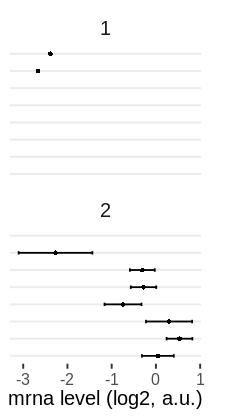

In [220]:
options(repr.plot.width=2, repr.plot.height=3.5)

plot_data2 <- plot_data %>% 
  bind_rows(all_8xdiaa_data) %>% 
  filter(diaa1 %in% c("HR", "RH"), diaa2 %in% c("RH", "HR")) %>% 
  mutate(insert = fct_rev(fct_reorder(insert, -repeat_length))) %>% 
  filter(replicate == 1) %>% 
  group_by(insert, repeat_length) %>% 
  mutate(num = group_indices())

plot1 <- plot_data2 %>% 
  ggplot(aes(x = lfc, y = num, shape = as.factor(replicate),
             xmin = lfc - lfc_sd, xmax = lfc + lfc_sd,
             )) +
  facet_wrap(~experiment, ncol = 1, scales = "fixed") +
  scale_y_continuous(position = "right", breaks = seq(1,8)) +
  # scale_color_manual(values = cbPalette[2:3]) +
  labs(color = "", y = "", x = "mrna level (log2, a.u.)") +
  geom_errorbar(width=0.2) +
  geom_point(size=1) +
  theme(axis.text.y = element_blank(), 
        axis.ticks.y = element_blank(), 
        panel.grid.major.y = element_line(),
        axis.line = element_blank(),
        legend.position = "none") +
  NULL
plot1

### Write RH + HR combinations to highlight pattern of variation

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(insert)`”


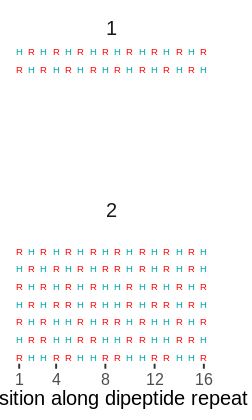

In [221]:
options(repr.plot.width=2.1, repr.plot.height=3.5)

plot2 <- plot_data2 %>% 
  select(num, replicate, repeat_length, experiment, insert) %>% 
  mutate(insert = str_split(insert, "")) %>% 
  mutate(insert = map(insert, enframe)) %>% 
  # rowwise() %>% 
  unnest() %>%
  rename(pos = name, aa = value) %>% 
  ggplot(aes(x = pos, y = num, color = aa, label = aa)) +
  facet_wrap(~experiment, ncol = 1, scales = "fixed") +
  geom_text(size = 2) +
  scale_y_continuous(position = "right") +
  scale_x_continuous(breaks = c(1,4,8,12,16)) +
  scale_color_manual(values = c("#00a5a7", "#ff0000")) +
  theme(axis.text.y = element_blank(), 
        axis.ticks.y = element_blank(), 
        axis.line = element_blank(),
        legend.position = "none") +
  labs(y = "", x = "Position along dipeptide repeat")
plot2

### Make a joint plot of RH-HR combination


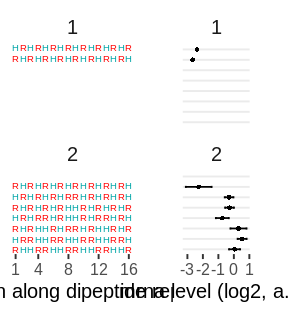

In [222]:
options(repr.plot.width=2.4, repr.plot.height=2.6)

cowplot::plot_grid(plot2, plot1, rel_widths = c(3,2))

ggsave("../figures/RH_HR_mix.pdf", width = 2.4, height = 2.6)


## Plot VK combination effects

### Parse VK combinations

In [223]:

plot_data <- insert_lfc %>% 
  filter(str_detect(insert_name, "mixdicodons") | insert == "VKVKVKVKVKVKVKVK" | insert == "KVKVKVKVKVKVKVKV") %>% 
  separate(insert_name, c("insert_type", "dicodon1", "dicodon2", "repeat_length")) %>%
  mutate(dicodon2 = if_else(is.na(repeat_length), dicodon1, dicodon2)) %>% 
  mutate(repeat_length = if_else(is.na(repeat_length), 8, as.numeric(repeat_length))) %>%
  type_convert() %>%
  mutate(diaa1 = as.character(translate(DNAStringSet(dicodon1), no.init.codon = T))) %>%
  mutate(diaa2 = as.character(translate(DNAStringSet(dicodon2), no.init.codon = T))) %>%
  select(-dicodon1, -dicodon2, -insert_type, -mean_lfc, -matches("n_barcodes|count")) %>%
  # pivot_wider(names_from = "repeat_length", values_from = c("mean_lfc", "insert")) %>%
  # arrange(mean_lfc_1 + mean_lfc_2 + mean_lfc_4) %>%
  mutate(experiment = 2) %>% 
  print()


Warning message:
“Expected 4 pieces. Missing pieces filled with `NA` in 2 rows [15, 16].”

── Column specification ────────────────────────────────────────────────────────
cols(
  seq = col_character(),
  insert_type = col_character(),
  dicodon1 = col_character(),
  dicodon2 = col_character(),
  insert = col_character()
)



# A tibble: 182 × 9
   replicate   lfc lfc_sd seq        repeat_length insert diaa1 diaa2 experiment
       <dbl> <dbl>  <dbl> <chr>              <dbl> <chr>  <chr> <chr>      <dbl>
 1         1 -3.92  1.47  AAAGTCAGT…             1 KVSFK… KV    SF             2
 2         2 -3.38  0.741 AAAGTCAGT…             1 KVSFK… KV    SF             2
 3         1 -3.69  0.757 AGTTTCAAA…             1 SFKVS… SF    KV             2
 4         2 -3.01  0.549 AGTTTCAAA…             1 SFKVS… SF    KV             2
 5         1 -3.84  0.829 TTCAGTGTC…             1 FSVKF… FS    VK             2
 6         2 -2.65  0.856 TTCAGTGTC…             1 FSVKF… FS    VK             2
 7         1 -2.65  0.550 GTCAAAGTC…             4 VKVKV… VK    SF             2
 8         2 -3.69  2.19  GTCAAAGTC…             4 VKVKV… VK    SF             2
 9         1 -2.28  0.558 AGTTTCAGT…             4 SFSFS… SF    KV             2
10         2 -2.91  0.800 AGTTTCAGT…             4 SFSFS… SF    KV             2
# … with

### Plot  mRNA level of VK + KV combinations


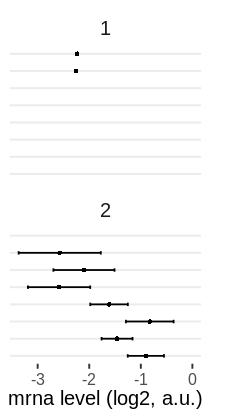

In [224]:
options(repr.plot.width=2, repr.plot.height=3.5)

plot_data2 <- plot_data %>% 
  bind_rows(all_8xdiaa_data) %>% 
  filter(diaa1 %in% c("VK", "KV"), diaa2 %in% c("VK", "KV")) %>% 
  mutate(insert = fct_rev(fct_reorder(insert, -repeat_length))) %>% 
  filter(replicate == 1) %>% 
  group_by(insert, repeat_length) %>% 
  mutate(num = group_indices())

plot1 <- plot_data2 %>% 
  ggplot(aes(x = lfc, y = num, shape = as.factor(replicate),
             xmin = lfc - lfc_sd, xmax = lfc + lfc_sd,
             )) +
  facet_wrap(~experiment, ncol = 1, scales = "fixed") +
  scale_y_continuous(position = "right", breaks = seq(1,8)) +
  scale_x_continuous(limits = c(NA, 0)) + 
  # scale_color_manual(values = cbPalette[2:3]) +
  labs(color = "", y = "", x = "mrna level (log2, a.u.)") +
  geom_errorbar(width=0.2) +
  geom_point(size=1) +
  theme(axis.text.y = element_blank(), 
        axis.ticks.y = element_blank(), 
        panel.grid.major.y = element_line(),
        axis.line = element_blank(),
        legend.position = "none") +
  NULL
plot1


### Write VK + KV combinations to highlight pattern of variation

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(insert)`”


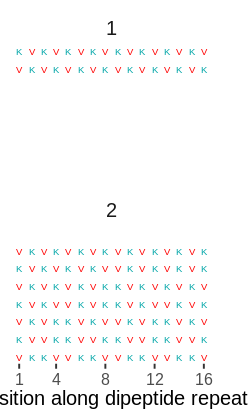

In [225]:
options(repr.plot.width=2.1, repr.plot.height=3.5)

plot2 <- plot_data2 %>% 
  select(num, replicate, repeat_length, experiment, insert) %>% 
  mutate(insert = str_split(insert, "")) %>% 
  mutate(insert = map(insert, enframe)) %>% 
  # rowwise() %>% 
  unnest() %>%
  rename(pos = name, aa = value) %>% 
  ggplot(aes(x = pos, y = num, color = aa, label = aa)) +
  facet_wrap(~experiment, ncol = 1, scales = "fixed") +
  geom_text(size = 2) +
  scale_y_continuous(position = "right") +
  scale_x_continuous(breaks = c(1,4,8,12,16)) +
  scale_color_manual(values = c("#00a5a7", "#ff0000")) +
  theme(axis.text.y = element_blank(), 
        axis.ticks.y = element_blank(), 
        axis.line = element_blank(),
        legend.position = "none") +
  labs(y = "", x = "Position along dipeptide repeat")
plot2


### Make a joint plot of VK-KV combination

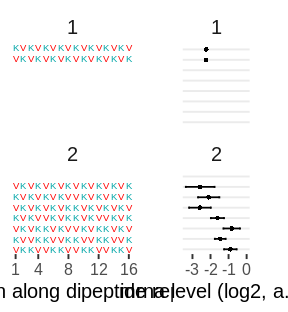

In [226]:
options(repr.plot.width=2.4, repr.plot.height=2.6)

cowplot::plot_grid(plot2, plot1, rel_widths = c(3,2))

ggsave("../figures/VK_KV_mix.pdf", width = 2.4, height = 2.6)

## Plot SF combination effects


### Parse all SF + FS combinations


In [227]:

plot_data <- insert_lfc %>% 
  filter(str_detect(insert_name, "mixdicodons") | insert == "FSFSFSFSFSFSFSFS" | insert == "SFSFSFSFSFSFSFSF") %>% 
  separate(insert_name, c("insert_type", "dicodon1", "dicodon2", "repeat_length")) %>%
  mutate(dicodon2 = if_else(is.na(repeat_length), dicodon1, dicodon2)) %>% 
  mutate(repeat_length = if_else(is.na(repeat_length), 8, as.numeric(repeat_length))) %>%
  type_convert() %>%
  mutate(diaa1 = as.character(translate(DNAStringSet(dicodon1), no.init.codon = T))) %>%
  mutate(diaa2 = as.character(translate(DNAStringSet(dicodon2), no.init.codon = T))) %>%
  select(-dicodon1, -dicodon2, -insert_type, -mean_lfc, -matches("n_barcodes|count")) %>%
  # pivot_wider(names_from = "repeat_length", values_from = c("mean_lfc", "insert")) %>%
  # arrange(mean_lfc_1 + mean_lfc_2 + mean_lfc_4) %>%
  mutate(experiment = 2) %>% 
  print()

Warning message:
“Expected 4 pieces. Missing pieces filled with `NA` in 2 rows [39, 40].”

── Column specification ────────────────────────────────────────────────────────
cols(
  seq = col_character(),
  insert_type = col_character(),
  dicodon1 = col_character(),
  dicodon2 = col_character(),
  insert = col_character()
)



# A tibble: 182 × 9
   replicate   lfc lfc_sd seq        repeat_length insert diaa1 diaa2 experiment
       <dbl> <dbl>  <dbl> <chr>              <dbl> <chr>  <chr> <chr>      <dbl>
 1         1 -3.92  1.47  AAAGTCAGT…             1 KVSFK… KV    SF             2
 2         2 -3.38  0.741 AAAGTCAGT…             1 KVSFK… KV    SF             2
 3         1 -3.69  0.757 AGTTTCAAA…             1 SFKVS… SF    KV             2
 4         2 -3.01  0.549 AGTTTCAAA…             1 SFKVS… SF    KV             2
 5         1 -3.84  0.829 TTCAGTGTC…             1 FSVKF… FS    VK             2
 6         2 -2.65  0.856 TTCAGTGTC…             1 FSVKF… FS    VK             2
 7         1 -2.65  0.550 GTCAAAGTC…             4 VKVKV… VK    SF             2
 8         2 -3.69  2.19  GTCAAAGTC…             4 VKVKV… VK    SF             2
 9         1 -2.28  0.558 AGTTTCAGT…             4 SFSFS… SF    KV             2
10         2 -2.91  0.800 AGTTTCAGT…             4 SFSFS… SF    KV             2
# … with

### Plot  mRNA level of SF + FS combinations
```{r, fig.width=2, fig.height=3.5}

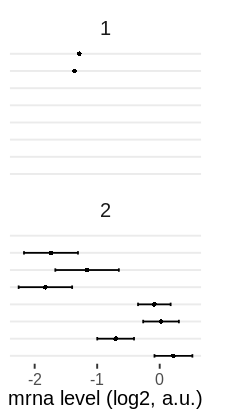

In [228]:
options(repr.plot.width=2, repr.plot.height=3.5)

plot_data2 <- plot_data %>% 
  bind_rows(all_8xdiaa_data) %>% 
  filter(diaa1 %in% c("SF", "FS"), diaa2 %in% c("SF", "FS")) %>% 
  mutate(insert = fct_rev(fct_reorder(insert, -repeat_length))) %>% 
  filter(replicate == 1) %>%
  group_by(insert, repeat_length) %>% 
  mutate(num = group_indices())

plot1 <- plot_data2 %>% 
  ggplot(aes(x = lfc, y = num, shape = as.factor(replicate),
             xmin = lfc - lfc_sd, xmax = lfc + lfc_sd,
             )) +
  facet_wrap(~experiment, ncol = 1, scales = "fixed") +
  scale_y_continuous(position = "right", breaks = seq(1,8)) +
  # scale_x_continuous(limits = c(NA, 0)) + 
  # scale_color_manual(values = cbPalette[2:3]) +
  labs(color = "", y = "", x = "mrna level (log2, a.u.)") +
  geom_errorbar(width=0.2) +
  geom_point(size=1) +
  theme(axis.text.y = element_blank(), 
        axis.ticks.y = element_blank(), 
        panel.grid.major.y = element_line(),
        axis.line = element_blank(),
        legend.position = "none") +
  NULL
plot1

### Write SF + FS combinations to highlight pattern of variation

```{r, fig.width=2.1, fig.height=3.5}

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(insert)`”


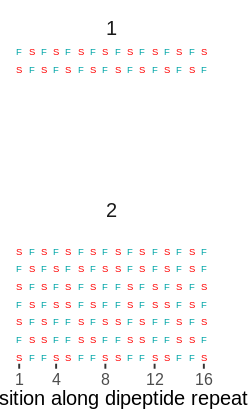

In [229]:
options(repr.plot.width=2.1, repr.plot.height=3.5)

plot2 <- plot_data2 %>% 
  select(num, replicate, repeat_length, experiment, insert) %>% 
  mutate(insert = str_split(insert, "")) %>% 
  mutate(insert = map(insert, enframe)) %>% 
  # rowwise() %>% 
  unnest() %>%
  rename(pos = name, aa = value) %>% 
  ggplot(aes(x = pos, y = num, color = aa, label = aa)) +
  facet_wrap(~experiment, ncol = 1, scales = "fixed") +
  geom_text(size = 2) +
  scale_y_continuous(position = "right") +
  scale_x_continuous(breaks = c(1,4,8,12,16)) +
  scale_color_manual(values = c("#00a5a7", "#ff0000")) +
  theme(axis.text.y = element_blank(), 
        axis.ticks.y = element_blank(), 
        axis.line = element_blank(),
        legend.position = "none") +
  labs(y = "", x = "Position along dipeptide repeat")
plot2


### Make a joint plot of SF-FS combination

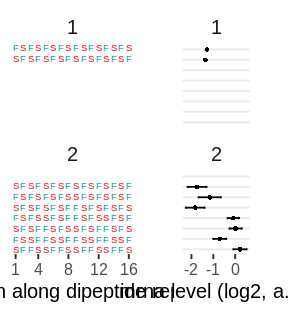

In [230]:
options(repr.plot.width=2.4, repr.plot.height=2.6)

cowplot::plot_grid(plot2, plot1, rel_widths = c(3,2))

ggsave("../figures/SF_FS_mix.pdf", width = 2.4, height = 2.6)


## Plot SF + VK alpha combinations

- Combinations form alpha helicies or beta strands  

### Parse all SF + VK alternating combinations

In [231]:

plot_data <- insert_lfc %>% 
  filter(str_detect(insert_name, "mixdicodons") | insert %in% c("SFSFSFSFSFSFSFSF", "VKVKVKVKVKVKVKVK")) %>% 
  separate(insert_name, c("insert_type", "dicodon1", "dicodon2", "repeat_length")) %>%
  mutate(dicodon2 = if_else(is.na(repeat_length), dicodon1, dicodon2)) %>% 
  mutate(repeat_length = if_else(is.na(repeat_length), 8, as.numeric(repeat_length))) %>%
  type_convert() %>%
  mutate(diaa1 = as.character(translate(DNAStringSet(dicodon1), no.init.codon = T))) %>%
  mutate(diaa2 = as.character(translate(DNAStringSet(dicodon2), no.init.codon = T))) %>%
  # select(-dicodon1, -dicodon2, -insert_type, -mean_lfc, -matches("n_barcodes|count")) %>%
  # pivot_wider(names_from = "repeat_length", values_from = c("mean_lfc", "insert")) %>%
  # arrange(mean_lfc_1 + mean_lfc_2 + mean_lfc_4) %>%
  mutate(experiment = 2) %>%
  arrange(repeat_length) %>%
  # filter(str_detect(insert, "SV|SK")) %>% 
  print()

Warning message:
“Expected 4 pieces. Missing pieces filled with `NA` in 4 rows [15, 16, 41, 42].”

── Column specification ────────────────────────────────────────────────────────
cols(
  seq = col_character(),
  insert_type = col_character(),
  dicodon1 = col_character(),
  dicodon2 = col_character(),
  insert = col_character()
)



# A tibble: 184 × 13
   replicate   lfc lfc_sd seq        insert_type dicodon1 dicodon2 repeat_length
       <dbl> <dbl>  <dbl> <chr>      <chr>       <chr>    <chr>            <dbl>
 1         1 -3.92  1.47  AAAGTCAGT… mixdicodons AAAGTC   AGTTTC               1
 2         2 -3.38  0.741 AAAGTCAGT… mixdicodons AAAGTC   AGTTTC               1
 3         1 -3.69  0.757 AGTTTCAAA… mixdicodons AGTTTC   AAAGTC               1
 4         2 -3.01  0.549 AGTTTCAAA… mixdicodons AGTTTC   AAAGTC               1
 5         1 -3.84  0.829 TTCAGTGTC… mixdicodons TTCAGT   GTCAAA               1
 6         2 -2.65  0.856 TTCAGTGTC… mixdicodons TTCAGT   GTCAAA               1
 7         1 -2.01  0.723 GTCAAATTC… mixdicodons GTCAAA   TTCAGT               1
 8         2 -1.71  0.623 GTCAAATTC… mixdicodons GTCAAA   TTCAGT               1
 9         1 -1.46  0.301 AAAGTCGTC… mixdicodons AAAGTC   GTCAAA               1
10         2 -1.48  0.473 AAAGTCGTC… mixdicodons AAAGTC   GTCAAA               1
# … wit

### Plot  mRNA level of SFVKx4 combinations

# A tibble: 8 × 15
# Groups:   insert [8]
  replicate    lfc lfc_sd seq        insert_type dicodon1 dicodon2 repeat_length
      <dbl>  <dbl>  <dbl> <chr>      <chr>       <chr>    <chr>            <dbl>
1         1 -3.92   1.47  AAAGTCAGT… mixdicodons AAAGTC   AGTTTC               1
2         1 -3.69   0.757 AGTTTCAAA… mixdicodons AGTTTC   AAAGTC               1
3         1 -3.84   0.829 TTCAGTGTC… mixdicodons TTCAGT   GTCAAA               1
4         1 -2.01   0.723 GTCAAATTC… mixdicodons GTCAAA   TTCAGT               1
5         1 -1.02   0.325 AGTTTCGTC… mixdicodons AGTTTC   GTCAAA               1
6         1 -0.103  0.194 GTCAAAAGT… mixdicodons GTCAAA   AGTTTC               1
7         1  0.217  0.307 TTCAGTAAA… mixdicodons TTCAGT   AAAGTC               1
8         1 -0.110  0.263 AAAGTCTTC… mixdicodons AAAGTC   TTCAGT               1
# … with 7 more variables: mean_lfc <dbl>, insert <fct>, diaa1 <chr>,
#   diaa2 <chr>, experiment <dbl>, num <int>, strand <lgl>


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


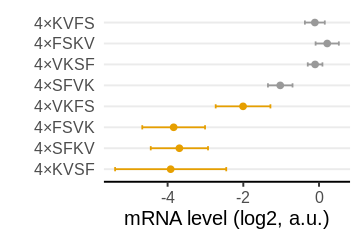

In [232]:
options(repr.plot.width=3, repr.plot.height=2)

plot_data2 <- plot_data %>% 
  bind_rows(all_8xdiaa_data) %>% 
  filter((diaa1 %in% c("VK", "KV") & diaa2 %in% c("SF", "FS")) | 
         (diaa2 %in% c("VK", "KV") & diaa1 %in% c("SF", "FS")) | 
         (diaa1 == diaa2 & diaa1 %in% c("VK", "KV", "SF", "FS"))) %>% 
  filter(repeat_length <= 1 | repeat_length >=9) %>% 
  mutate(insert = fct_rev(fct_reorder(paste0("4×", substr(insert, 1, 4)), -lfc))) %>% 
  # mutate(diaa1 = fct_relevel(diaa1, "SF", "FS", "VK", "KV")) %>% 
  # mutate(diaa2 = fct_relevel(diaa2, "SF", "FS", "VK", "KV")) %>% 
  # group_by(repeat_length, diaa1, diaa2) %>% 
  filter(replicate == 1) %>% 
  group_by(insert) %>% 
  mutate(num = group_indices()) %>% 
  mutate(strand = if_else(str_detect(insert, "KVSF|VKFS|SFKV|FSVK"), T, F)) %>% 
  print()

plot1 <- plot_data2 %>% 
  ggplot(aes(x = lfc, y = insert, color = strand,
             xmin = lfc - lfc_sd, xmax = lfc + lfc_sd)) +
  # scale_y_continuous(position = "right", breaks = seq(1,12)) +
  scale_x_continuous(breaks = seq(-6, 0, 2)) +
  scale_color_manual(values = cbPalette[1:2]) +
  labs(color = "", y = "", x = "mRNA level (log2, a.u.)", shape = "replicate") +
  geom_errorbar(width = 0.2) +
  geom_point() +
  theme(axis.ticks.y = element_blank(), 
        panel.grid.major.y = element_line(),
        axis.line.y = element_blank(),
        legend.position = "right") +
  guides(color = F) +
  NULL

ggsave("../figures/SVKF_mrna_levels.pdf", width = 3, height = 2)

plot1